In [3]:
import cv2
import numpy as np
import os
import time
from matplotlib import pyplot as plt

In [4]:
img_name = 'dog1.jpg'
# Reading image to an object (we will display it in the next step).
img = cv2.imread(img_name)

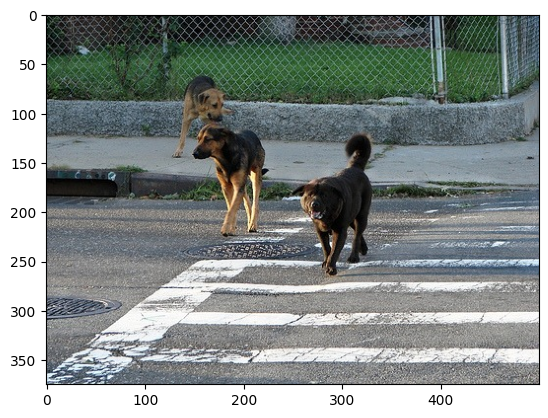

In [5]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
# Load class names and set random colors
classes = open('coco.names').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

In [8]:
# Load YOLO model and Setting Backend and Target
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
# net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU) # Uncomment if GPU support␣is not available

In [9]:
 # Get output layer names
ln = net.getLayerNames()
len(ln)


254

In [10]:
print(ln)

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36', 'shortcut_36', 'conv_37', 'bn_37', 'leaky_

In [11]:
# Construct a blob from the image :::: is used to prepare an image for input␣
#into a deep learning model. Also ensures compatible with the YOLO model,
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)


In [12]:
# Set input to prepared image blob as the input for the YOLO network
net.setInput(blob)


In [13]:
# Perform forward pass
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
print('It took %.3f seconds to process the image.' % (t - t0))


It took 4.968 seconds to process the image.


Blob shape=(1, 3, 412, 412)


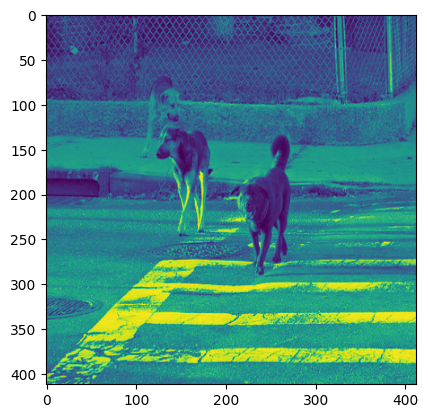

In [14]:
# Construct a blob from the image
blob = cv2.dnn.blobFromImage(img, 1/255.0, (412, 412), swapRB=True, crop=False)
r = blob[0, 0, :, :]
plt.imshow(r)
print('Blob shape=%s' % (blob.shape,))


Image preview:


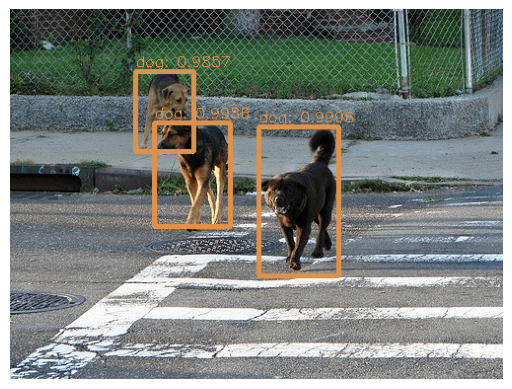

In [16]:
# Assuming 'img' is your input image and 'outputs' is the result from the␣network
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]
# Iterate over each of the layer outputs
for output in outputs:
    for detection in output:
        scores = detection[5:]
        if len(scores) == 0:
            continue # Skip if no scores are present
        classID = np.argmax(scores)
        if classID >= len(scores):
            print(f"Warning: classID {classID} is out of bounds for scores array with size {len(scores)}")
            continue
        confidence = scores[classID]
        if not np.isscalar(confidence):
            print(f"Warning: Confidence is not a scalar value, it's a {type(confidence)}")
            continue
        if confidence > 0.5: # Confidence threshold
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)
# Apply Non-Maximum Suppression to suppress weak, overlapping bounding boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
# Ensure at least one detection
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        # Draw the bounding box
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 4)
        # Draw the label and confidence
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
# Display the image
print('Image preview:')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
